# **Datos de Game Spot**
***

**IMPORTANTE: NO HACER CORRER LOS CODIGOS. varios procesos se fueron haciendo en el camino, y no están terminados como para que se repliquen,
los que se muestra aquí es una versión amigable de entender lo que se ha podido hacer.**

## Librerias a ocupar
***

In [30]:
#Interactuar con el API
import requests
import json
from time import sleep

#procesamiento de datos
import numpy as np
import pandas as pd
import builtins
import os
import re

#Visualización de datos
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow.parquet as pq



## Datos obtenidos con la API de Game Spot
***

### Informacion y requisitos de la API
***

El API de Game Stop es de uso publico con la conción de no ocuparse con fines licrativos ni para competor con este.

Para poder ocuparla es necesarion crearse una cuenta en su sitio web, después dirigirse a la dirección del API, aceptar los terminos y condiciones y por ultimo crear tu Key para acceder al API.

A travez de esta uno puede acceder a distintos datos (Juegos, Entregas, Articulos, etcetera), en este caso nosotroa nos centraremos en las reseñas:

El URL del API para reseñas:  http://www.gamespot.com/api/reviews/?api_key=[Key personal]




### Interacción con la API
***

Primero veremos la función que implementará el *request()*

In [4]:
def gamespotapi (llave: str, sesion: requests.session, offset: int):

    url='http://www.gamespot.com/api/reviews/?'

    parametros = {
        'api_key': llave,
        'format': 'json',       #Si no se especifica el request devuelde un HTML
        'offset': f'{offset}'   #Para poder hacer multiples requests
    }

    for _ in range(10):
        try:
            respuesta = sesion.get(f'{url}', headers= sesion.headers, params=parametros)
            respuesta.raise_for_status()
            return respuesta.json()
        
        except requests.exceptions.HTTPError as e:
            print("HTTPError:", e)
            sleep(6)

        except requests.exceptions.RequestException as e:
            print("Error de red:", e)            # Este fue el error más comun
            sleep(6)


Luego la funcion que limpia los datos y los guarda en un csv

In [ ]:
def diccionarios_a_csv(documento, lista, primero=False):

    if isinstance(lista, str):   #se asegura que no sea string
        lista = json.loads(lista)

    df=pd.json_normalize(lista, sep='_')  #como el nombre está indentado se debe normalizar
    df=df[['game_name','score','publish_date','game_id']]          #unicos datos rescatables
    df = df.reset_index(drop=True)        #se quita el index
    
    modo = 'w' if primero else 'a'        #por si se crea o se agrega
    escribir_header = primero             #por si es el primero

    df.to_csv(documento, mode=modo, header=escribir_header, index=False) #guarda la información

Por otra parte está el codigo principal que se encarga de hacer los multiples requests y descargas:

In [6]:
doc="Partes_separadas_del_proyecto/Alonso/llave.txt" # Aquí tengo guardada mi Key

with open(doc , mode="r", encoding="utf-8") as lista: #se obtiene la llave
    llave = lista.readline().rstrip()


sesion= requests.session()  #se crea la sesion para optimizar los request
sesion.headers.update({'User-Agent': 'PUC Student proyect: https://github.com/claudiocanales721/Proyecto-cs-de-datos (aaqueveque@estudante.uc.cl)'})

#La documetación especificó que User-Agents comunes no serían haceptados
# así que preferí entregar la mayor cantidar de informacion sobre el request

offset=0    #Esta es la variable que define que parte de los request tomar, va de 100 en 100
no_ultimo=True   #Para terminar el priceso cuando se halla legado al final
contontador=1    #Me sirve para ver cuantos request llevo
primero=True
while no_ultimo:

    respuesta=gamespotapi(llave,sesion,offset) #Se ocupa la funcion definida
    juegos=respuesta['results']                #esta es la información que nos interesa de la respuesta

    if len(juegos) < 100:             #Para terminar el priceso cuando se halla legado al final
        no_ultimo=False

    diccionarios_a_csv('data/gamespot.csv', juegos, primero) #se usa la función para
                                                            #agregar elementos al documento
    
    offset+=100       #Se actualiza el offset para no repetir descargas
    print(f'Se guardó el request N°{contador}, con {len(juegos)} juegos, en total hay {offset} juegos')
    contador+=1       #Para tener el feedback que todo va bien

FileNotFoundError: [Errno 2] No such file or directory: 'data/gamespot_reseñas.json'

### Formato de las respuestas
***

{
    
    "publish_date": str almacena la fecha con la hora de la publicacion de la reseña
    "update_date": str almacena la fecha con la hora de la ultima modificacion
    "review_type": str que puede tener "primary", "secondary" o "second take"
    "id": int que representa el id de la reseña
    "authors": str con el nombre del autor de la reseña
    "title": str con el titulo de la reseña, nomalemte es "[Nombre del Juego] Review"
    "image": diccionario que entrega imagenes en url, ocupa las siguentes keys:
            "square_tiny", "screen_tiny", "square_small", "original"

    "score": str con un numero del 1 al 10 que puede tener decimales
    "deck": str resumen de la reseña
    "good": str lo bueno del juego
    "bad": str lo malo del juego
    "body": str el cuerpo de la reseña
    "lede": str encabesado de la reseña
    "game": diccionario que tiene:
        "id": int con el id del juego
        "name": nombre del juego
        "api_detail_url": str con el url del API del juego
        "site_detail_url": str con el url del juego
    ,
    "releases": Lista de diccionarios con la informacion de la entrega
                en distintas partes del mundo:
        
            "upc": str codigo universal del producto
            "distribution_type": str con el tipo de distribucion
            "id": int con el id del realease de esa zona
            "name": str con el nombre del juego
            "region": Zona del mundo que se lanza el juego
            "platform": str con la plataforma en la que se juega el juego
            "api_detail_url": str con el url del "release"
        ,
    
    "site_detail_url": str del url de la reseña del juego
}

In [16]:
with open("data/gamespot.csv", "r", encoding='utf-8') as f:
    df = pd.read_csv(f)

df.head()

,nombre,nota,publicacion,id
0,Under a Killing Moon,6.9,1996-05-01 12:00:00,2230.0
1,Warcraft II: Tides of Darkness,9.3,1996-05-01 12:00:00,2298.0
2,Warhammer: Shadow of the Horned Rat,6.8,1996-05-01 12:00:00,2304.0
3,Whiplash (1996),6.1,1996-05-01 12:00:00,2320.0
4,Wing Commander IV: The Price of Freedom,8.5,1996-05-01 12:00:00,2330.0


In [18]:
"""df_limpio = df.rename(columns={'game_name': 'nombre',
                    'score': 'nota',
                    'publish_date': 'publicacion',
                    'game_id': 'id'})"""


df_limpio = df.dropna(subset=['nombre',
                    'nota',
                    'publicacion','id'])

df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15156 entries, 0 to 15299
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   nombre       15156 non-null  object 
 1   nota         15156 non-null  float64
 2   publicacion  15156 non-null  object 
 3   id           15156 non-null  float64
dtypes: float64(2), object(2)
memory usage: 592.0+ KB


In [ ]:


df_limpio['publicacion'] = pd.to_datetime(df_limpio['publicacion'], errors= 'coerce')

df_limpio['nota']=pd.to_numeric(df_limpio['nota'])

df_limpio['id']=pd.to_numeric(df_limpio['id'])

df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15156 entries, 0 to 15299
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   nombre       15156 non-null  object        
 1   nota         15156 non-null  float64       
 2   publicacion  15156 non-null  datetime64[ns]
 3   id           15156 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 592.0+ KB


C:\Users\alonso aqueveque\AppData\Local\Temp\ipykernel_8848\3254170344.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio['publicacion'] = pd.to_datetime(df_limpio['publicacion'], errors= 'coerce')
C:\Users\alonso aqueveque\AppData\Local\Temp\ipykernel_8848\3254170344.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio['nota']=pd.to_numeric(df_limpio['nota'])
C:\Users\alonso aqueveque\AppData\Local\Temp\ipykernel_8848\3254170344.py:5: SettingWithCopyWarning: 
A value is trying to be set

In [ ]:
# Se usa la misma funcion definida para la base de datos de steam
def obtener_nombre_base(titulo):
    
    if not isinstance(titulo, str):
        return titulo
    
    base = re.sub(r':.*', '', titulo)
    base = re.sub(r'\s*\(.*\)', '', base)
    base = re.sub(r'\s*\[.*\]', '', base)
    base = re.sub(r'\s+([IVX\d]+)$', '', base)
    base = re.sub(r'\s+(GOTY|Remastered|Definitive Edition)$', '', base, flags=re.IGNORECASE)
    
    return base.strip()

df_limpio['nombre_franquicia']=df_limpio['nombre'].apply(obtener_nombre_base)

Sagas = df_limpio.groupby('Nombre_Base')['id'].count()

C:\Users\alonso aqueveque\AppData\Local\Temp\ipykernel_8848\2281043223.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio['nombre_franquicia']=df_limpio['nombre'].apply(obtener_nombre_base)


In [23]:
df_limpio = df_limpio.sort_values(by=['nombre_franquicia','publicacion'])

df_limpio = df_limpio.groupby('nombre_franquicia').first().reset_index()

In [28]:
df_limpio.sample(5)

,nombre_franquicia,nombre,nota,publicacion,id
1162,Code Vein,Code Vein,6.0,2019-09-26 07:00:00,464088.0
303,Amplitude,Amplitude (2003),8.8,2003-03-26 03:35:57,18016.0
1433,Dark Messiah of Might and Magic,Dark Messiah of Might and Magic,6.7,2006-10-26 07:23:51,25001.0
64,50 Cent,50 Cent: Bulletproof,4.8,2005-11-28 05:37:11,23514.0
4866,Punch King,Punch King,6.5,2002-06-27 06:19:24,4221.0


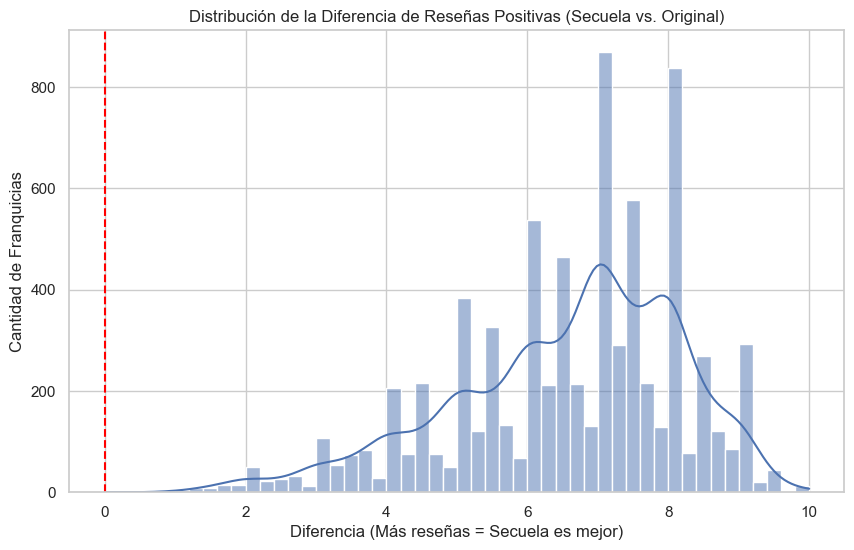

In [31]:
sns.set_theme(style="whitegrid")


plt.figure(figsize=(10, 6))
sns.histplot(df_limpio['nota'], kde=True, bins=50)  


plt.axvline(x=0, color='red', linestyle='--')

plt.title('Distribución de la Diferencia de Reseñas Positivas (Secuela vs. Original)')
plt.xlabel('Diferencia (Más reseñas = Secuela es mejor)')
plt.ylabel('Cantidad de Franquicias')
plt.show()

# POR HACER
***

En este proceso quedan varias cosas pendientes, se queda atras con las exploraciones de las otras bases de datos, pero tiene otros aspectos donde puede dar una nueva perspectiva.

Para la proxima entrega de esta exploracion queda pendiente:

-El igualar la profundidad del EDA
-Notamos que en la base de datos hay más de una reseña por juego así que se podría elegir el sesgo, que puede ser quedarse con la nota mas nueva por que la opinion del juego cambio y envejeció mal o quedarse con la primera dado que fue la primera impresion, ya que estan los casos como cyberpunk 2077 que empezo mal pero impresión nota ha mejorado